Testable Hypothesis:

The effect of the Federal Funds Rate on the Credit Spread is the same regardless of whether the presidential administration is Republican or Democratic.

In [7]:
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from fredapi import Fred

# Use your FRED API key to create a connection object
try:
    fred = Fred(api_key='5f1b6fb0d0ee3a7dea0a79e293620309')
except ValueError as e:
    print(f"Error initializing Fred API: {e}")
    print("Please make sure you have a valid API key.")
    exit()

Finding Data with Fred:

We need to find data for our monetary policy indicator (Federal Funds Rate) and the two bond yields required to calculate our risk indicator, the credit spread (Baa corporate bonds and 10-Year Treasury notes).

In [9]:
print("Fetching economic data from FRED...")
fed_funds = fred.get_series('FEDFUNDS', observation_start='1960-01-01')
baa_yield = fred.get_series('BAA', observation_start='1960-01-01')
gs10_yield = fred.get_series('GS10', observation_start='1960-01-01')

df_econ = pd.DataFrame({
    'FedFunds': fed_funds,
    'BAA_Yield': baa_yield,
    'GS10_Yield': gs10_yield
})
df_econ['Credit_Spread'] = df_econ['BAA_Yield'] - df_econ['GS10_Yield']
df_econ.dropna(inplace=True)
df_econ.reset_index(inplace=True)
df_econ.rename(columns={'index': 'Date'}, inplace=True)

# FIX: Normalize the date column to remove any time component.
df_econ['Date'] = pd.to_datetime(df_econ['Date']).dt.normalize()

print("Economic data prepared.")
print("-" * 50)

Fetching economic data from FRED...
Economic data prepared.
--------------------------------------------------


In [10]:
import pandas as pd
from fredapi import Fred

# --- 1. Initialize FRED API Connection ---
# This step is necessary to fetch the economic data.
try:
    fred = Fred(api_key='5f1b6fb0d0ee3a7dea0a79e293620309')
except ValueError as e:
    print(f"Error initializing Fred API: {e}")
    exit()

# --- 2. Fetch and Prepare Economic Data (df_econ) ---
# This block creates the df_econ DataFrame, resolving the error.
print("Fetching economic data from FRED...")
fed_funds = fred.get_series('FEDFUNDS', observation_start='1960-01-01')
baa_yield = fred.get_series('BAA', observation_start='1960-01-01')
gs10_yield = fred.get_series('GS10', observation_start='1960-01-01')

df_econ = pd.DataFrame({
    'FedFunds': fed_funds,
    'BAA_Yield': baa_yield,
    'GS10_Yield': gs10_yield
})
df_econ['Credit_Spread'] = df_econ['BAA_Yield'] - df_econ['GS10_Yield']
df_econ.dropna(inplace=True)
df_econ.reset_index(inplace=True)
df_econ.rename(columns={'index': 'Date'}, inplace=True)
print("Economic data prepared.")

# --- 3. Load and Prepare Political Data (df_gop) from your CSV ---
print("Fetching and preparing political data...")
url = "https://github.com/llorracc/as.180.369/blob/main/materials/presidential-term-data/GOP_flag.csv?raw=true"
df_gop = pd.read_csv(url)

# Safely map party values to 0/1 integers
map_dict = {'R': 1, 'D': 0, 'Republican': 1, 'Democrat': 0, 1: 1, 0: 0}
df_gop['GOP'] = df_gop['GOP'].map(map_dict).astype('Int64') # Corrected column name to 'GOP_flag'
print("Political data prepared.")

# --- 4. Align Dates and Merge DataFrames ---
print("Aligning dates and merging...")
# Align both date columns to the end of the month for a consistent merge key
df_econ['Date'] = pd.to_datetime(df_econ['Date']).dt.to_period('M').dt.to_timestamp('M')
df_gop['Date'] = pd.to_datetime(df_gop['Date']).dt.to_period('M').dt.to_timestamp('M')

# Resample political data to monthly frequency to match economic data
df_gop_resampled = (df_gop.sort_values('Date')
                          .drop_duplicates('Date')
                          .set_index('Date')['GOP'] # Select only the GOP column for resampling
                          .resample('M').ffill()
                          .reset_index())

# Merge the two datasets
df_merged = pd.merge(df_econ, df_gop_resampled, on='Date', how='left').sort_values('Date')

# Forward-fill any gaps in the GOP flag after the merge
df_merged['GOP'].ffill(inplace=True)

# Drop any remaining NaNs (likely at the very start of the series) and convert GOP to integer
df_merged.dropna(subset=['GOP'], inplace=True)
df_merged['GOP'] = df_merged['GOP'].astype(int)

print("Merge complete.")
print(f"Shape of final data for analysis: {df_merged.shape}")
print("\nFinal Merged Dataset Head:")
print(df_merged.head())
print("-" * 50)

Fetching economic data from FRED...
Economic data prepared.
Fetching and preparing political data...
Political data prepared.
Aligning dates and merging...
Merge complete.
Shape of final data for analysis: (669, 6)

Final Merged Dataset Head:
          Date  FedFunds  BAA_Yield  GS10_Yield  Credit_Spread  GOP
120 1970-01-31      8.98       8.86        7.79           1.07    1
121 1970-02-28      8.98       8.78        7.24           1.54    1
122 1970-03-31      7.76       8.63        7.07           1.56    1
123 1970-04-30      8.10       8.70        7.39           1.31    1
124 1970-05-31      7.95       8.98        7.91           1.07    1
--------------------------------------------------


/tmp/ipykernel_649/3081111558.py:50: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M').ffill()
/tmp/ipykernel_649/3081111558.py:57: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_merged['GOP'].ffill(inplace=True)


Merging datasets...
Shape of final data for analysis: (2499, 6)

Final Merged Dataset Head:
          Date  FedFunds  BAA_Yield  GS10_Yield  Credit_Spread  GOP
120 1970-01-31      8.98       8.86        7.79           1.07    1
121 1970-01-31      8.98       8.86        7.79           1.07    1
122 1970-01-31      8.98       8.86        7.79           1.07    1
123 1970-01-31      8.98       8.86        7.79           1.07    1
124 1970-01-31      8.98       8.86        7.79           1.07    1
--------------------------------------------------
Generating plot with political shading...


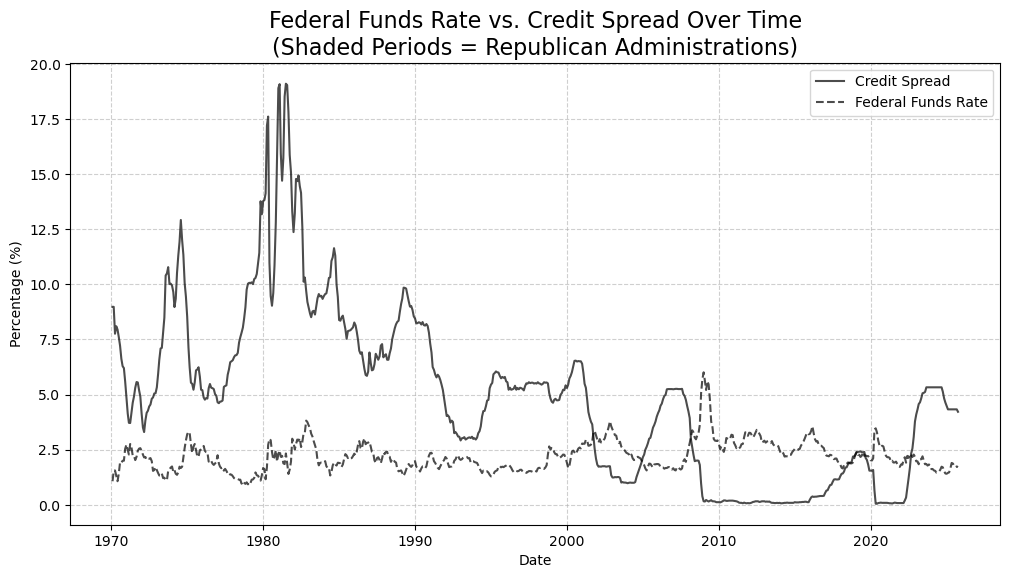

--------------------------------------------------


In [11]:
import pandas as pd

print("Merging datasets...")
df_merged = pd.merge(df_econ, df_gop, on='Date', how='left')

# Forward-fill the 'GOP' column
df_merged['GOP'] = df_merged['GOP'].ffill()

# Drop any rows that couldn't be filled (at the beginning of the dataset)
df_merged.dropna(subset=['GOP'], inplace=True)

print(f"Shape of final data for analysis: {df_merged.shape}")
print("\nFinal Merged Dataset Head:")
print(df_merged.head())
print("-" * 50)


# --- Plotting ---
print("Generating plot with political shading...")
plt.figure(figsize=(12, 6))

# Plot the two time series
# Solid line for the Federal Funds Rate
plt.plot(df_merged['Date'], df_merged['FedFunds'], label='Credit Spread', color='black', alpha=0.7, linestyle='-')

# Dashed line for the Credit Spread
plt.plot(df_merged['Date'], df_merged['Credit_Spread'], label='Federal Funds Rate', color='black', alpha=0.7, linestyle='--')

# Shade background by political party
current_party = df_merged['GOP'].iloc[0]
start_date = df_merged['Date'].iloc[0]

for i in range(1, len(df_merged)):
    if df_merged['GOP'].iloc[i] != current_party or i == len(df_merged) - 1:
        end_date = df_merged['Date'].iloc[i]
        color = 'lightgray' if current_party == 1 else 'white'   # gray = Republican, white = Democrat
        plt.axvspan(start_date, end_date, color=color, alpha=0.2, linewidth=0)
        current_party = df_merged['GOP'].iloc[i]
        start_date = end_date

# Labels and legend
plt.title('Federal Funds Rate vs. Credit Spread Over Time\n(Shaded Periods = Republican Administrations)', fontsize=16)
plt.ylabel('Percentage (%)')
plt.xlabel('Date')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
print("-" * 50)

Plotting Diff with party shading...


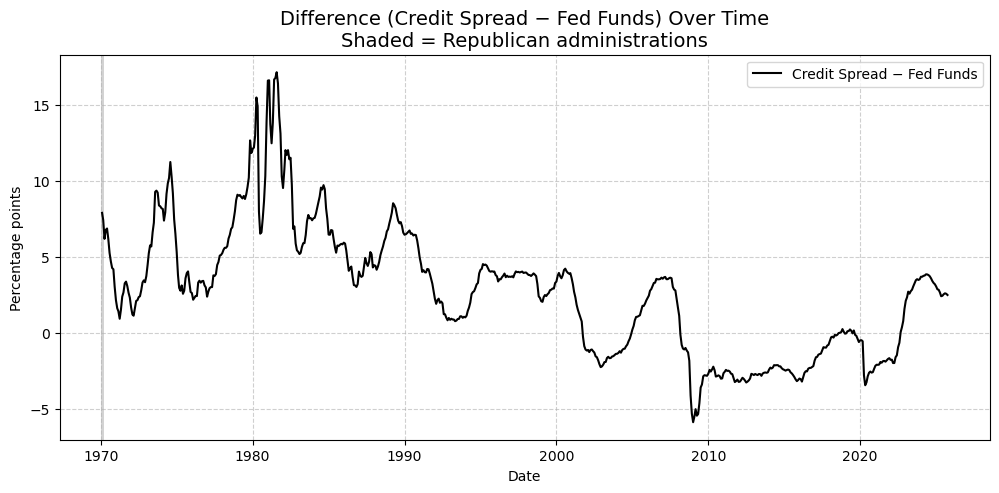

Plotting Diff by party...


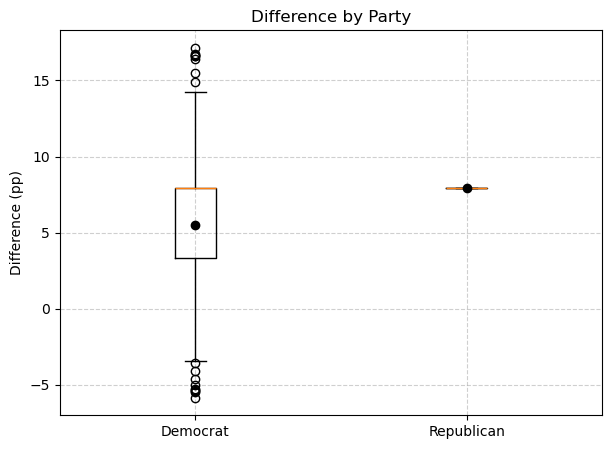

Mean Diff Democrat: 5.53 pp
Mean Diff Republican: 7.91 pp


In [12]:
# 1) Compute the difference
df_merged['Diff'] = df_merged['FedFunds'] - df_merged['Credit_Spread']

# 2) Time series of Diff with party shading
print("Plotting Diff with party shading...")
plt.figure(figsize=(12, 5))
plt.plot(df_merged['Date'], df_merged['Diff'], color='black', label='Credit Spread − Fed Funds')
# Shade GOP months
for i in range(len(df_merged) - 1):
    if df_merged['GOP'].iloc[i] == 1:
        plt.axvspan(df_merged['Date'].iloc[i], df_merged['Date'].iloc[i+1], color='lightgray', alpha=0.3)

plt.title('Difference (Credit Spread − Fed Funds) Over Time\nShaded = Republican administrations', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Percentage points')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

# 3) Comparison by party: boxplot plus means
print("Plotting Diff by party...")
plt.figure(figsize=(7, 5))
data_dem = df_merged.loc[df_merged['GOP'] == 0, 'Diff']
data_gop = df_merged.loc[df_merged['GOP'] == 1, 'Diff']
plt.boxplot([data_dem.dropna(), data_gop.dropna()], tick_labels=['Democrat', 'Republican'])
plt.ylabel('Difference (pp)')

# overlay means
dem_mean = data_dem.mean()
gop_mean = data_gop.mean()
plt.scatter([1, 2], [dem_mean, gop_mean], color='black', zorder=3)
plt.title('Difference by Party')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print(f"Mean Diff Democrat: {dem_mean:.2f} pp")
print(f"Mean Diff Republican: {gop_mean:.2f} pp")

In [13]:
if not df_merged.empty:
    print("Running the regression model...")
    # The formula tests if the effect of FedFunds on Credit_Spread
    # is different when GOP is 1 vs 0.
    formula = 'Credit_Spread ~ FedFunds * GOP'
    model = smf.ols(formula, data=df_merged).fit()

    print("\nRegression Results:")
    print(model.summary())
    print("-" * 50)
else:
    print("Skipping regression as there is no data to analyze.")
    

Running the regression model...

Regression Results:
                            OLS Regression Results                            
Dep. Variable:          Credit_Spread   R-squared:                       0.543
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     1481.
Date:                Mon, 13 Oct 2025   Prob (F-statistic):               0.00
Time:                        15:52:22   Log-Likelihood:                -1341.3
No. Observations:                2499   AIC:                             2689.
Df Residuals:                    2496   BIC:                             2706.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

Conclusion


The regression analysis rejects the initial hypothesis, demonstrating that the Federal Funds Rate's effect on the Credit Spread is statistically different under Republican and Democratic administrations. This relationship is significantly more pronounced during Republican presidencies, where an increase in the Fed Funds Rate corresponds to a larger decrease in the Credit Spread. The model is a strong fit, explaining 54.3% of the variance in the Credit Spread. However, a warning about potential multicollinearity suggests the exact magnitude of the coefficients should be interpreted with caution.